# Applied DataScience - Clustering Localities in Kolkata, India
## Arghyadeep Ganguly
### 28th JAN 2020

## Introduction/Business Problem

In our citi of Kolkata(India), famously known as City Of Joy , Kolkata is the commercial and financial hub of East and North-East India and home to the Calcutta Stock Exchange.It is a major commercial and military port, and is the only city in eastern India, apart from Bhubaneswar to have an international airport.

Around 6 million people lives in this city with population density of 22 thousand people per square kilometer. This city has been devided into 140 wards. When we think of it by the investor, we expect from them to prefer the districts where the type of business they want to install is less intense. If we think of the city residents, they may want to choose the regions where real estate values are lower, too. At the same time, they may want to choose the district according to the social places density. However, it is difficult to obtain information that will guide investors in this direction, nowadays.


## A short description of the useful data


There are no available dataset in csv/json/xls format which has enlisted all Kolkata negubourhoods with latitiude and lomgitude data. 

This data is only available in Wikipedia. Every Kolkata Corporation Wards have a separate Wiki pages and that contains geospatial data. I am planning to run a process that will hit every Wikipedia page (for each Kolkata ward) and will collect relevent information.

An Example Kolkata Corporation Ward Page - "https://en.wikipedia.org/wiki/Ward_No._1,_Kolkata_Municipal_Corporation"

Exmaple Data Set, That can be extracted from Wiki Pages 

Coordinates: 22.617889°N 88.370556°ECoordinates: 22.617889°N 88.370556°E
Country :	 India
State:	West Bengal
City:	Kolkata
Neighbourhood covered :	Cossipore
Police station:	Cossipore
Parliamentary constituency:	Kolkata Uttar
Assembly constituency:	Kashipur-Belgachhia

We will consider to pull Coordinates, Ward No and Assembly constituency( as Neighbourhood).

Our next dataset would be Fousqaure venue data. After collecting nearby venues for available kolkata geographical points, those will be filtered to consider only categories which can be marked as eatries.

After analyzing Foursquare Explore api data set which can be accessed with below API calls

https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}


# Methodology

## Data Collection

There are no available dataset in csv/json/xls format which has enlisted all Kolkata negubourhoods with latitiude and lomgitude data.

This data is only available in Wikipedia. Every Kolkata Corporation Wards have a separate Wiki pages and that contains geospatial data. I am planning to run a process that will hit every Wikipedia page (for each Kolkata ward) and will collect relevent information.

An Example Kolkata Corporation Ward Page - "https://en.wikipedia.org/wiki/Ward_No._1,_Kolkata_Municipal_Corporation"


Exmaple Data Set, That can be extracted from Wiki Pages

Coordinates: 22.617889°N 88.370556°ECoordinates: 22.617889°N 88.370556°E Country : India State: West Bengal City: Kolkata Neighbourhood covered : Cossipore Police station: Cossipore Parliamentary constituency: Kolkata Uttar Assembly constituency: Kashipur-Belgachhia

We will consider to pull Coordinates, Ward No and Assembly constituency( as Neighbourhood).

Our next dataset would be Fousqaure venue data. After collecting nearby venues for available kolkata geographical points, those will be filtered to consider only categories which can be marked as eatries.

After analyzing Foursquare Explore api data set which can be accessed with below API calls

https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}

### Import and Install all required Packages

Panadas & Numpy - For Data extraction and manipulation

Folium & Geopy - For gespatial Data analysis

Matplotlib - Charts

In [2]:

!conda install -c conda-forge folium=0.10.1
!conda install -c conda-forge geopy --yes 

import pandas as pd
import numpy as np

import folium
from geopy.geocoders import Nominatim 
import requests
import json
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.10.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.3.1-py_0        conda-forge
    folium:   

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') 

In [4]:
CLIENT_ID = 'FWTZSMHN2LO3ASEOMNMJKKROKEJM0BWXS34XGRY4TSCEBQ4Y' # your Foursquare ID
CLIENT_SECRET = 'M4GZJY12ZXNG4KRAZIQQZVNFPIINOLHTPLIG1QRKTRS3IWKJ' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FWTZSMHN2LO3ASEOMNMJKKROKEJM0BWXS34XGRY4TSCEBQ4Y
CLIENT_SECRET:M4GZJY12ZXNG4KRAZIQQZVNFPIINOLHTPLIG1QRKTRS3IWKJ


### Extracting Corodinates from Web scrapped Data

Now, We will start collecting/ preparing our data from Kolkata Corporatin Wiki Pages. We have used Pandas read_html(link) method to read data from Wiki pages. We are interested to collect data of "Ward no", "Ward Name", "Borough", "Postal Code", "locality","latitude","longitude".
 
 In this data preparation phase, We will iterate through all available Wiki pages for all 144 Wards.
 
 Issues We have faced during Extraction :- 
  
  
  a) Extracted text data for coordinates include junk charecters like - "\ufeff"
  
  b) Coordinates includes "°E" and "°N". This suffix information has to be revomed to work with Folium maps.
  

In [5]:
def extract_longitude_latitude (coordinates):
    #first \ufeff location
    sub_startindex = coordinates.index("\ufeff") + 5 # length of the junk text
    sub_endindex = coordinates[sub_startindex:].index("Coordinates")
    stage_one_coordinates = coordinates[sub_startindex: sub_startindex+sub_endindex]
    lst_lat_lang = stage_one_coordinates.rsplit(" ")
    return  lst_lat_lang [1].replace("°E",""), lst_lat_lang [0].replace("°N","")

In [6]:
npary = np.array([["ward_no","ward","borough","postalcode","locality","latitude","longitude"]])

In [7]:
def populate_details_wardwise(src_dtframe):
    
    var_ward_no ='{0}'.format(activeward_no)
    var_ward = src_dtframe[second_column][src_dtframe[first_column].isin(['Neighbourhoods covered','Neighbourhood covered','Neighbourhoods','Neighbourhood']) ].to_string(index=False).strip()
    var_bor = src_dtframe[second_column][src_dtframe[first_column].isin (['Burough' , 'Borough']) ].to_string(index=False).strip()
    var_postal = src_dtframe[second_column][src_dtframe[first_column] == 'PIN' ].to_string(index=False).strip()
    var_local = src_dtframe[second_column][src_dtframe[first_column] == 'Assembly constituency' ].to_string(index=False).strip()

    coordinates = src_dtframe[second_column][2]
    var_lang,var_lat = extract_longitude_latitude(coordinates)
    return [[var_ward_no,var_ward,var_bor,var_postal,var_local,var_lat,var_lang]]

In [8]:

maxward_no = 144
activeward_no = 1

while activeward_no <= maxward_no:
    
    first_column = 'Ward No. {0}'.format(activeward_no)
    second_column = 'Ward No. {0}.1'.format(activeward_no)

    link = "https://en.wikipedia.org/wiki/Ward_No._{0},_Kolkata_Municipal_Corporation".format(activeward_no)
    tables = pd.read_html(link)
    rw_dtframe = pd.DataFrame(tables[0])
    npary = np.concatenate((npary,populate_details_wardwise(rw_dtframe)) ,axis =0)
    activeward_no += 1
#print(npary)

### Extracted Data frame 

The below output will show, how the initial data frame with extracted data will looklike 

In [9]:
pd.set_option('display.max_rows', None)

df_kolkata = pd.DataFrame(npary)
df_kolkata.columns = df_kolkata.iloc[0]
df_kolkata = df_kolkata[1:]
df_kolkata = df_kolkata.astype({"borough":int, "longitude":float , "latitude":float},inplace=True)
df_kolkata.sort_values(['borough'],ascending=True)

,ward_no,ward,borough,postalcode,locality,latitude,longitude
1,1,Cossipore,1,700 003,Kashipur-Belgachhia,22.617889,88.370556
2,2,Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,1,700 050,Kashipur-Belgachhia,22.628056,88.384444
3,3,"Belgachia, Duttabagan",1,700 037,Kashipur-Belgachhia,22.604444,88.383333
4,4,Paikpara,1,700 002/ 700 037,Kashipur-Belgachhia,22.613056,88.379444
5,5,Tala,1,700 002,Kashipur-Belgachhia,22.608889,88.379694
6,6,"Chitpur, Cossipore",1,700 002,Kashipur-Belgachhia,22.610863,88.371213
7,7,Bagbazar,1,700 003,Shyampukur,22.603567,88.365806
8,8,"Bagbazar, Shyampukur",1,700 003,Shyampukur,22.601806,88.366500
9,9,"Shobhabazar, Kumortuli",1,700 004,Shyampukur,22.595889,88.365306
20,20,"Shobhabazar, Ahiritola",2,700 049,Shyampukur,22.593556,88.354667


### Populating Missing Data with dummy values

After observing the dataframe data, We have identified 3 Wards (Jika,Garden Reach (Akshay Kanan),Paikpara) which do not contain any postalcode information. We have manually assigned values for those. 

In [10]:
#Data Cleaning 
df_kolkata.loc[df_kolkata["ward"] == 'Joka',"postalcode"] = '700 104'
df_kolkata.loc[df_kolkata["ward"] == 'Garden Reach (Akshay Kanan)',"postalcode"] = '700 024'
df_kolkata.loc[df_kolkata["ward"] == 'Paikpara',"postalcode"] = '700 002, 700 037'

#df_kolkata['longitude'] = df_kolkata['longitude'].replace("N","")
df_kolkata.head()



,ward_no,ward,borough,postalcode,locality,latitude,longitude
1,1,Cossipore,1,700 003,Kashipur-Belgachhia,22.617889,88.370556
2,2,Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,1,700 050,Kashipur-Belgachhia,22.628056,88.384444
3,3,"Belgachia, Duttabagan",1,700 037,Kashipur-Belgachhia,22.604444,88.383333
4,4,Paikpara,1,"700 002, 700 037",Kashipur-Belgachhia,22.613056,88.379444
5,5,Tala,1,700 002,Kashipur-Belgachhia,22.608889,88.379694


### Projection of Data Points on Folium Map

Here we see map of kolkata with blue circles pointing each wards. Folium CircleMaker method has been used to create these circles by passing latitude and longitude data from above data frame. Folium Popup method has been used to create pop-ups with Ward name and neighborhood/locality name data.This popup will be visible whenever an user will click on these blue circles

In [11]:
map_kolkata = folium.Map(width=1000,height=500,location=[22.568889, 88.346167], zoom_start=11)

for lat, lng, ward, neighborhood in zip( df_kolkata['latitude'],df_kolkata['longitude'], df_kolkata['ward'],df_kolkata['locality']):
    label = '{}| {}'.format(ward,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kolkata)  
map_kolkata.add_child(folium.LatLngPopup())
map_kolkata

In [12]:
#df_kolkata.reset_index(inplace=True)
latitude = '22.532889'
longitude = '88.343472'
search_query = ''
radius = 1000
LIMIT = 50

#df_kolkata.iloc[0]

### Preparing url

Preparing url to call Explore Api , provided my Foursquare. We will use "explore" api to collect nearby venues from each ward.

In [13]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=FWTZSMHN2LO3ASEOMNMJKKROKEJM0BWXS34XGRY4TSCEBQ4Y&client_secret=M4GZJY12ZXNG4KRAZIQQZVNFPIINOLHTPLIG1QRKTRS3IWKJ&v=20190605&ll=22.532889,88.343472&radius=1000&limit=50'

In [14]:
results = requests.get(url).json()

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']

### Example Data Frame
This is how an example data frame may look. There are numerious fileds returned by foursquare but we will only consider venue-name, venue-categories,venue-location-lat,venue-location-lang

In [17]:
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Balaram Mullick & Radharaman Mullick,Indian Sweet Shop,22.533097,88.347082
1,Balwant Singh's Eating House,Dhaba,22.537714,88.344220
2,Balwant Singh's Snack Corner,Fast Food Restaurant,22.537709,88.344228
3,Tyre Patty,Café,22.538048,88.349169
4,Privy Ultra Lounge,Nightclub,22.538145,88.351121
5,The Bikers Cafe,American Restaurant,22.537719,88.348993
6,McDonald's,Fast Food Restaurant,22.536206,88.346353
7,Chai Break,Tea Room,22.539382,88.347070
8,Cafe Coffee Day,Café,22.525476,88.345297
9,Harish Park,Park,22.530499,88.343569


In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

13 venues were returned by Foursquare.


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('{}|lat:{},lang:{}'.format(name,lat,lng))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### All venues

We have prepared getNearbyVenue() method to pull and populate a dataframe with all venues for each wards (venues available in 1000 meter radius.

In [20]:
kolkata_venues = getNearbyVenues(names=df_kolkata['ward'],
                                   latitudes=df_kolkata['latitude'],
                                   longitudes=df_kolkata['longitude']
                                  )

Cossipore|lat:22.617889,lang:88.370556
Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...|lat:22.628056,lang:88.384444
Belgachia, Duttabagan|lat:22.604444,lang:88.383333
Paikpara|lat:22.613056,lang:88.379444
Tala|lat:22.608889,lang:88.379694
Chitpur, Cossipore|lat:22.610863,lang:88.371213
Bagbazar|lat:22.603567,lang:88.365806
Bagbazar, Shyampukur|lat:22.601806,lang:88.3665
Shobhabazar, Kumortuli|lat:22.595889,lang:88.365306
Shyambazar, Shobhabazar, Shyampukur|lat:22.597889,lang:88.364326
Shyambazar, Burtolla, Hatibagan|lat:22.598806,lang:88.373611
Shyambazar (Fariapukur)|lat:22.596806,lang:88.376694
Ultadanga (Daspara-Muchi Bazar-Telenga Bagan-S...|lat:22.594167,lang:88.385889
Ultadanga (Murari Pukur), Bagmari|lat:22.589278,lang:88.385556
Maniktala (Bangiya Sahitya Parishad-Halsi Baga...|lat:22.590278,lang:88.376556
Maniktala (Bangiya Sahitya Parishad-Goa Bagan)|lat:22.591278,lang:88.371361
Shobhabazar, Darjipara|lat:22.595378,lang:88.365556
Shobhabazar|lat:22.593667,lang:88.362861
Ahir

Grouping venues using neighborhood and generating counts.

In [21]:
print(kolkata_venues.shape)
kolkata_venues.groupby('Neighborhood').count()

(549, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ahiritola and Beniatola,1,1,1,1,1,1
Alipore,7,7,7,7,7,7
"Ashok Nagar, Kudghat, Tollygunge Club, Regent ...",3,3,3,3,3,3
"Badartala, Rajabagan",1,1,1,1,1,1
Bagbazar,6,6,6,6,6,6
"Bagbazar, Shyampukur",4,4,4,4,4,4
"Baghajatin (Ajanta Park), Garia (Phool Bagan-G...",1,1,1,1,1,1
"Ballygunge (Ballygunge Park), Park Circus (Gob...",10,10,10,10,10,10
Ballygunge (Ballygunge Place-Ekdalia-Ballygung...,7,7,7,7,7,7


### Exploring Unique Data Categories

In [22]:
print('There are {} uniques categories.'.format(len(kolkata_venues['Venue Category'].unique())))
kolkata_venues['Venue Category'].unique()

There are 116 uniques categories.


array(['Playground', 'Burger Joint', 'Train Station', 'Music Venue',
       'Watch Shop', 'Bank', 'Park', 'Pier', 'River',
       'Chinese Restaurant', 'Neighborhood', 'Metro Station',
       'Indian Sweet Shop', 'Fast Food Restaurant', 'Market',
       'Indian Restaurant', 'Plaza', 'Vegetarian / Vegan Restaurant',
       'Mughlai Restaurant', 'Pizza Place', 'Bus Stop',
       'Dumpling Restaurant', 'Gym', 'ATM', "Men's Store",
       'Clothing Store', 'Café', 'Historic Site', 'Theater',
       'Indie Movie Theater', 'Bengali Restaurant', 'Fried Chicken Joint',
       'Food', 'Boat or Ferry', 'IT Services', 'Candy Store',
       "Women's Store", 'Comfort Food Restaurant', 'Snack Place',
       'History Museum', 'Art Museum', 'Museum', 'Asian Restaurant',
       'Bakery', 'Dessert Shop', 'Department Store', 'Coffee Shop',
       'Electronics Store', 'Dhaba', 'Tea Room', 'Pharmacy', 'Hotel',
       'Platform', 'Movie Theater', 'Tram Station',
       'Paper / Office Supplies Store', 'Book

### Creating broader categories

This is a very important stepin our reporting. We do not want to get confused by hundreds of different venue categories available in Foursqaure. We have planned to create few bigger/major categories and want to include available categories to Any of these major categories. We have planned to mark these data to belwo major categories.

'Hospital & Medical'  
'Fitness & Sports'
'Eatries'
'Transport',
'Plaza'
'Stores'
'Financial Institution'
'River & Waterbody',
'Neighborhood'
'Business'
'Hotel',
'Health & Beauty', 
'Hostel',
'Campground',
'Nightclub',

In [27]:
kolkata_venues.loc[kolkata_venues['Venue Category'].isin (['Chinese Restaurant',
 'Indian Sweet Shop',
 'Indian Restaurant',
 'Mughlai Restaurant',
 'Dumpling Restaurant',
 'Café',
 'Bengali Restaurant',
 'Asian Restaurant',
 'Tea Room',
 'Breakfast Spot',
 'South Indian Restaurant',
 'Beer Garden',
 'Italian Restaurant',
 'Gastropub',
 'Irish Pub',
 'American Restaurant',
 'Awadhi Restaurant',
 'Kerala Restaurant',
 'Falafel Restaurant',
 'Food Truck',
 'Burger Joint',
 'Fried Chicken Joint',
 'Snack Place',
 'Restaurant',
 'Bakery',
 'Coffee Shop',
 'Theme Restaurant',
 'Bistro',
 'Fast Food Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Food',
 'Candy Store',
 'Dessert Shop',
 'Pub',
 'Mexican Restaurant',
 'Tex-Mex Restaurant',
 'Ice Cream Shop',
 'Diner',
 'Dhaba',
 'Sandwich Place',
                                                          'Pizza Place','Juice Bar','Lounge',
'Gujarati Restaurant','Food Service','Tibetan Restaurant',
'North Indian Restaurant','Home Service','BBQ Joint','Chaat Place','Comfort Food Restaurant']
),'Venue Category'] = 'Eatries'


kolkata_venues.loc[kolkata_venues['Venue Category'].isin (['Harbor / Marina',
 'Market',
 'IT Services',
 'Business Service',
 'Flea Market',
'Supermarket'
]
),'Venue Category'] = 'Business'

kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([ 'Bank',
 'Insurance Office',
 'ATM'
]
),'Venue Category'] = 'Financial Institution'

kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([ 'Golf Course',
 'Gym',
 'Sports Club',
 'Gym / Fitness Center',
 'Park',
 'Pool',
 'Theme Park',
 'Garden',
 'Athletics & Sports',
 'Yoga Studio',
 'Playground',  
 'Dance Studio',
                                                           'Martial Arts Dojo'
]
),'Venue Category'] = 'Fitness & Sports'

kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([  'Health & Beauty Service'
]
),'Venue Category'] = 'Health & Beauty'

kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([  'Pharmacy'
]
),'Venue Category'] = 'Hospital & Medical'

kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([  'Art Museum',
'Performing Arts Venue',
 'Plaza',
 'Multiplex',
 'Indie Movie Theater',
 'History Museum',
 'Movie Theater',
 'Shopping Mall',
 'Museum',
'Music Venue',
                                                           'Historic Site', 
'Theater','Trail','Circus'

]
),'Venue Category'] = 'Plaza'

kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([   'River',
                                                           'Pier','Lake','Hotel Pool'
]
),'Venue Category'] = 'River & Waterbody'

kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([ 
'Watch Shop',
'Department Store',
'Furniture / Home Store',
'Photography Studio',
'Paper / Office Supplies Store',
 'Jewelry Store',
 "Women's Store",
 'Auto Garage',
 'Tailor Shop',
 'Gift Shop',
 'Arts & Crafts Store',
 'Music Store',
 'Mobile Phone Shop',
 "Men's Store",
 'Print Shop',
 'Electronics Store',
 'Sporting Goods Shop',
 'Clothing Store',
 'Bookstore',
 'Convenience Store',
 'Bagel Shop','Food & Drink Shop','Frozen Yogurt Shop','Grocery Store','Boutique','Optical Shop','Shoe Store', 'Bridal Shop',
       'Pet Store', 'Shipping Store','Motorcycle Shop', 'Deli / Bodega']),'Venue Category'] ='Stores'


kolkata_venues.loc[kolkata_venues['Venue Category'].isin ([ 
'Boat or Ferry',
'Light Rail Station',
 'Platform',
 'Train Station',
 'Metro Station',
 'Bus Stop',
 'Tram Station',
 'Bus Station',
 'Taxi Stand']),'Venue Category'] = 'Transport'




In [28]:
kolkata_venues['Venue Category'].unique()

array(['Fitness & Sports', 'Eatries', 'Transport', 'Plaza', 'Stores',
       'Financial Institution', 'River & Waterbody', 'Neighborhood',
       'Business', 'Hospital & Medical', 'Hotel', 'Health & Beauty',
       'Hostel', 'Campground', 'Nightclub', 'Bed & Breakfast'],
      dtype=object)

### Grouping data baesd upon Ward Name / Neighborhood

In [29]:
print(kolkata_venues.shape)
#kolkata_eatries.groupby('Neighborhood').count()
kolkata_venues_grouped = kolkata_venues.groupby('Neighborhood').count().reset_index()
kolkata_venues_grouped = kolkata_venues_grouped [["Neighborhood","Venue"]]
kolkata_venues_grouped.head()

(549, 7)


,Neighborhood,Venue
0,Ahiritola and Beniatola,1
1,Alipore,7
2,"Ashok Nagar, Kudghat, Tollygunge Club, Regent ...",3
3,"Badartala, Rajabagan",1
4,Bagbazar,6


### Implementing onehot encoding

Here we have used "Venue Category" in get_dummies method and created columns for each venue category type.

In [30]:
# one hot encoding
kolkata_onehot = pd.get_dummies(kolkata_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kolkata_onehot['Neighborhood'] = kolkata_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kolkata_onehot.columns[8]] + list(kolkata_onehot.columns[:8])+ list(kolkata_onehot.columns[9:])
kolkata_onehot = kolkata_onehot[fixed_columns]

kolkata_onehot.head()

,Hostel,Bed & Breakfast,Business,Campground,Eatries,Financial Institution,Fitness & Sports,Health & Beauty,Hospital & Medical,Hotel,Neighborhood,Nightclub,Plaza,River & Waterbody,Stores,Transport
0,0,0,0,0,0,0,1,0,0,0,Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,"Belgachia, Duttabagan",0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,"Belgachia, Duttabagan",0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,Paikpara,0,0,0,0,0


The data frame has been grouped again with neighborhood and Mean() calculated

In [34]:
kolkata_grouped = kolkata_onehot.groupby('Neighborhood').mean().reset_index()
kolkata_grouped.head()

,Neighborhood,Hostel,Bed & Breakfast,Business,Campground,Eatries,Financial Institution,Fitness & Sports,Health & Beauty,Hospital & Medical,Hotel,Nightclub,Plaza,River & Waterbody,Stores,Transport
0,Ahiritola and Beniatola,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,Alipore,0.0,0.0,0.0,0.0,0.857143,0.000000,0.000000,0.0,0.0,0.142857,0.0,0.0,0.000000,0.000000,0.0
2,"Ashok Nagar, Kudghat, Tollygunge Club, Regent ...",0.0,0.0,0.0,0.0,0.666667,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.0
3,"Badartala, Rajabagan",0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,Bagbazar,0.0,0.0,0.0,0.0,0.166667,0.166667,0.166667,0.0,0.0,0.000000,0.0,0.0,0.333333,0.000000,0.0


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Then I created a table which shows list of top 10 venue category for each neighbourhood in below table.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kolkata_grouped['Neighborhood']

for ind in np.arange(kolkata_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kolkata_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahiritola and Beniatola,Eatries,Transport,Stores,River & Waterbody,Plaza,Nightclub,Hotel,Hospital & Medical,Health & Beauty,Fitness & Sports
1,Alipore,Eatries,Hotel,Transport,Stores,River & Waterbody,Plaza,Nightclub,Hospital & Medical,Health & Beauty,Fitness & Sports
2,"Ashok Nagar, Kudghat, Tollygunge Club, Regent ...",Eatries,Stores,Transport,River & Waterbody,Plaza,Nightclub,Hotel,Hospital & Medical,Health & Beauty,Fitness & Sports
3,"Badartala, Rajabagan",Financial Institution,Transport,Stores,River & Waterbody,Plaza,Nightclub,Hotel,Hospital & Medical,Health & Beauty,Fitness & Sports
4,Bagbazar,River & Waterbody,Fitness & Sports,Financial Institution,Eatries,Transport,Stores,Plaza,Nightclub,Hotel,Hospital & Medical


### K Mean clustering

We have some common venue categories in boroughs. In this reason I used unsupervised learning K-means algorithm to cluster the boroughs. K-Means algorithm is one of the most common cluster method of unsupervised learning.

First, I will run K-Means to cluster the wards into 6 clusters 

In [37]:
clusterNum = 6

kolkata_grouped_clustering = kolkata_grouped.drop('Neighborhood',1)
k_means2 = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means2.fit(kolkata_grouped_clustering)
k_means2.labels_


array([0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 4, 0, 2, 4, 5, 2,
       3, 3, 1, 0, 2, 2, 0, 4, 0, 4, 0, 4, 0, 2, 0, 4, 5, 0, 0, 2, 0, 0,
       2, 2, 4, 1, 1, 0, 2, 5, 1, 5, 0, 2, 2, 3, 0, 5, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 0, 4, 2, 1, 0, 1, 1, 0, 0, 4, 4, 2, 0, 2, 1, 0, 2, 0, 4,
       4, 4, 4, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 2, 2,
       1, 5, 0, 5, 0, 3, 4, 0, 1, 5, 2], dtype=int32)

Here is the merged table with cluster labels for each ward. If you check the below table then you can identify few wards where Fousqaure could not provide any venue location. We have decided to create a remaining cluster with all wards where Foursquare could not return any details. We will identify that cluster with 6. This will be our 7th Cluster.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_means2.labels_)

kolkata_merged = df_kolkata

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kolkata_merged = kolkata_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='ward')
 # check the last columns!
kolkata_merged.head()

,ward_no,ward,borough,postalcode,locality,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,1,Cossipore,1,700 003,Kashipur-Belgachhia,22.617889,88.370556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,1,700 050,Kashipur-Belgachhia,22.628056,88.384444,0.0,Fitness & Sports,Eatries,Transport,Stores,River & Waterbody,Plaza,Nightclub,Hotel,Hospital & Medical,Health & Beauty
3,3,"Belgachia, Duttabagan",1,700 037,Kashipur-Belgachhia,22.604444,88.383333,3.0,Transport,Stores,River & Waterbody,Plaza,Nightclub,Hotel,Hospital & Medical,Health & Beauty,Fitness & Sports,Financial Institution
4,4,Paikpara,1,"700 002, 700 037",Kashipur-Belgachhia,22.613056,88.379444,4.0,Plaza,Fitness & Sports,Transport,Stores,River & Waterbody,Nightclub,Hotel,Hospital & Medical,Health & Beauty,Financial Institution
5,5,Tala,1,700 002,Kashipur-Belgachhia,22.608889,88.379694,3.0,Transport,Plaza,Stores,River & Waterbody,Nightclub,Hotel,Hospital & Medical,Health & Beauty,Fitness & Sports,Financial Institution


In [39]:
kolkata_merged_with_nan =  kolkata_merged[['latitude','longitude','ward','Cluster Labels']]
kolkata_merged_with_nan= kolkata_merged_with_nan.fillna(6.0)
kolkata_merged_with_nan.head()

,latitude,longitude,ward,Cluster Labels
1,22.617889,88.370556,Cossipore,6.0
2,22.628056,88.384444,Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,0.0
3,22.604444,88.383333,"Belgachia, Duttabagan",3.0
4,22.613056,88.379444,Paikpara,4.0
5,22.608889,88.379694,Tala,3.0


### Exploring Clusters with Maps and charts

In [40]:
map_clusters = folium.Map(height= 500, width = 1000,
                          location=[22.568889, 88.346167], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum+2)
ys = [i + x + (i*x)**2 for i in range(clusterNum+2)] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

rainbow 

['#8000ff',
 '#386df9',
 '#12c8e6',
 '#5af8c8',
 '#a4f89f',
 '#ecc86f',
 '#ff6d38',
 '#ff0000']

In [41]:

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kolkata_merged_with_nan['latitude'], kolkata_merged_with_nan['longitude'],kolkata_merged_with_nan['ward'], kolkata_merged_with_nan['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)+1],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [42]:

kolkata_grouped_count = kolkata_onehot.groupby('Neighborhood').sum().reset_index()
kolkata_merged_2 = kolkata_grouped_count 

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kolkata_merged_2 = kolkata_merged_2.join(neighborhoods_venues_sorted[['Neighborhood','Cluster Labels']].set_index('Neighborhood'), on='Neighborhood')
 # check the last columns!
kolkata_grouped_cluster = kolkata_merged_2.groupby('Cluster Labels').mean().reset_index()
kolkata_grouped_cluster.head()

,Cluster Labels,Hostel,Bed & Breakfast,Business,Campground,Eatries,Financial Institution,Fitness & Sports,Health & Beauty,Hospital & Medical,Hotel,Nightclub,Plaza,River & Waterbody,Stores,Transport
0,0,0.000000,0.019231,0.211538,0.000000,4.403846,0.038462,0.173077,0.000000,0.000000,0.211538,0.076923,0.653846,0.019231,0.576923,0.192308
1,1,0.000000,0.000000,0.153846,0.000000,0.000000,1.307692,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.076923
2,2,0.037037,0.000000,0.296296,0.074074,1.185185,0.259259,0.333333,0.074074,0.148148,0.259259,0.000000,0.148148,0.111111,0.814815,0.407407
3,3,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,1.333333
4,4,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.933333,0.000000,0.000000,0.133333,0.000000,1.066667,0.000000,0.133333,0.200000


In [43]:
categoryCount = len(kolkata_venues['Venue Category'].unique())

x = np.arange(categoryCount)
ys = [i + x + (i*x)**2 for i in range(categoryCount)] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
color_pallet = [colors.rgb2hex(i) for i in colors_array]



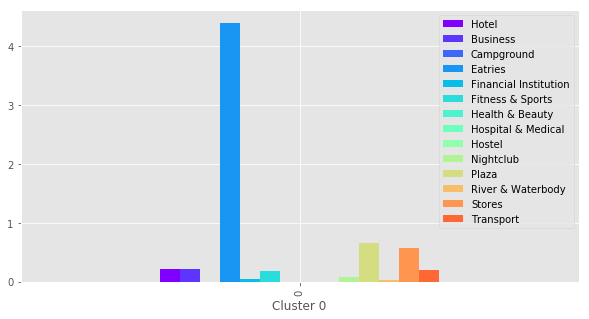

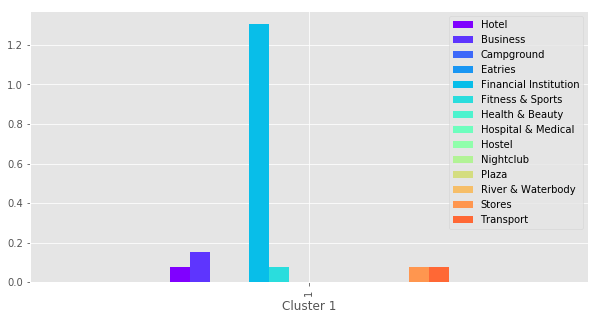

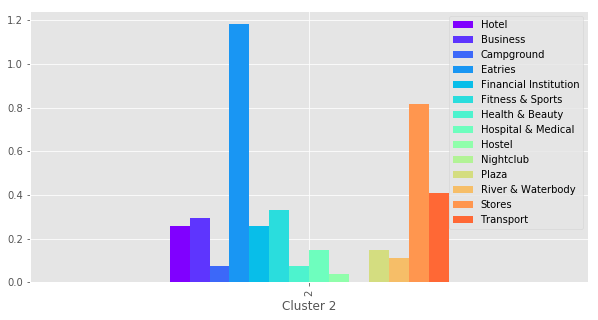

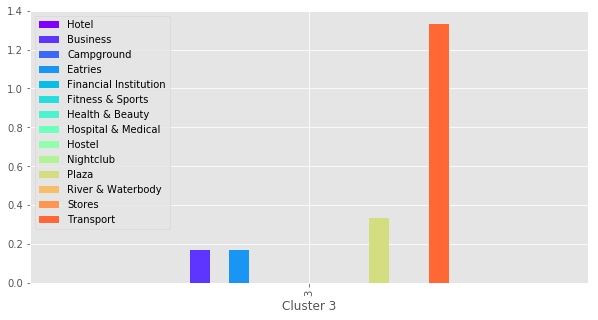

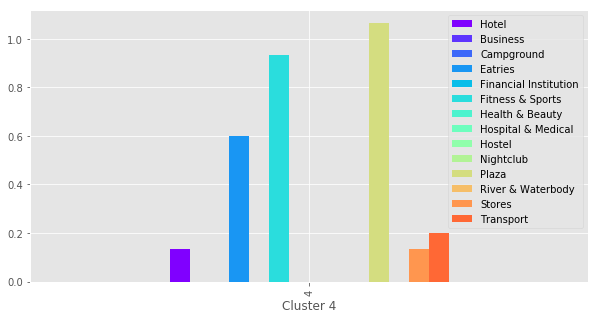

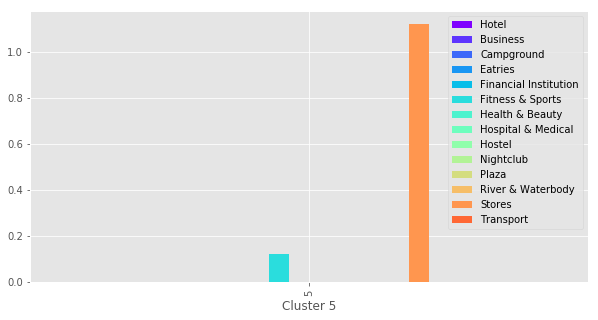

In [44]:
kolkata_grouped_cluster[kolkata_grouped_cluster['Cluster Labels'] == 0][['Hotel','Business','Campground','Eatries','Financial Institution','Fitness & Sports','Health & Beauty','Hospital & Medical','Hostel','Nightclub','Plaza','River & Waterbody','Stores','Transport']] .plot(kind='bar', figsize=(10, 5) , color = color_pallet )

plt.xlabel ('Cluster 0')
plt.show()

kolkata_grouped_cluster[kolkata_grouped_cluster['Cluster Labels'] == 1][['Hotel','Business','Campground','Eatries','Financial Institution','Fitness & Sports','Health & Beauty','Hospital & Medical','Hostel','Nightclub','Plaza','River & Waterbody','Stores','Transport']] .plot(kind='bar', figsize=(10, 5), color = color_pallet)

plt.xlabel ('Cluster 1')
plt.show()

kolkata_grouped_cluster[kolkata_grouped_cluster['Cluster Labels'] == 2][['Hotel','Business','Campground','Eatries','Financial Institution','Fitness & Sports','Health & Beauty','Hospital & Medical','Hostel','Nightclub','Plaza','River & Waterbody','Stores','Transport']] .plot(kind='bar', figsize=(10, 5), color = color_pallet)

plt.xlabel ('Cluster 2')
plt.show()

kolkata_grouped_cluster[kolkata_grouped_cluster['Cluster Labels'] == 3][['Hotel','Business','Campground','Eatries','Financial Institution','Fitness & Sports','Health & Beauty','Hospital & Medical','Hostel','Nightclub','Plaza','River & Waterbody','Stores','Transport']] .plot(kind='bar', figsize=(10, 5), color = color_pallet)

plt.xlabel ('Cluster 3')
plt.show()

kolkata_grouped_cluster[kolkata_grouped_cluster['Cluster Labels'] == 4][['Hotel','Business','Campground','Eatries','Financial Institution','Fitness & Sports','Health & Beauty','Hospital & Medical','Hostel','Nightclub','Plaza','River & Waterbody','Stores','Transport']] .plot(kind='bar', figsize=(10, 5), color = color_pallet)

plt.xlabel ('Cluster 4')
plt.show()

kolkata_grouped_cluster[kolkata_grouped_cluster['Cluster Labels'] == 5][['Hotel','Business','Campground','Eatries','Financial Institution','Fitness & Sports','Health & Beauty','Hospital & Medical','Hostel','Nightclub','Plaza','River & Waterbody','Stores','Transport']] .plot(kind='bar', figsize=(10, 5), color = color_pallet)

plt.xlabel ('Cluster 5')
plt.show()



## Results



 In the result section, I would like to heilight three major outcomes of this project.
 
 1. We could segregate kolkata wards depending upon different available amenities 
 2. We could identify most common venues for all kolkata Wards.
 3. Different charecteristies of every cluster was shown using bar charts. One cluster might have more number of eatries and other might have high on financial institutions.
 
 Cluster 0 - More Eatries and nore than other major type of venues available
 
 Cluster 1 - More financial institution but less other venues
 
 Cluster 2 - Best Clusters, nearly all major categories of vanues are available.
 
 Cluster 3 - Good transpotation but very few other venues
 
 Cluster 4 - Many Plazas that suggest lots of shops an business with higher location desireability 
 
 Cluster 5 - Only Stores...
 
 
 New residents or new investors can identify there cluster of choice by identifying abandance or scarcity of type of venues in each cluster.

## Conclusion 

This project has tried to provide venue data with different view points. New residents or new investors can identify there cluster of choice by identifying abandance or scarcity of type of venues in each cluster.



## References

Wikipedia -https://en.wikipedia.org/wiki/Kolkata

Wikipedia (Ward level) - "https://en.wikipedia.org/wiki/Ward_No._1,_Kolkata_Municipal_Corporation"

Foursquare API
